In [1]:
import os
os.environ["TORCH_CUDA_ARCH_LIST"] = "8.9" # for RTX 4060

import mitsuba as mi
mi.set_variant('cuda_ad_rgb')
import drjit as dr
dr.set_flag(dr.JitFlag.LoopRecord, False)
dr.set_flag(dr.JitFlag.VCallRecord, False)

import sys
sys.path.append('..')
from models.neubsdf import *
from models.neureparam import NeuReparam
from models.neumip import NeuBTF, NeuMIP
from utils import binning2d, angle2xyz

import matplotlib.pyplot as plt
from tqdm import tqdm

## Demo scene in mitsuba dict

In [2]:
def get_scene(bsdf,integrator,width=800,height=800):
    fac = 7
    rad = 2.
    r = 0.01
    return {
        'type': 'scene',
        'camera': {
            'type': 'perspective',
            'fov': 30,
            'to_world': mi.ScalarTransform4f.look_at(
                origin=[0,3.1,6.08],
                target=[0,0.0,0.0],
                up=[0,1,0]
            ),
            'film': {
                'type': 'hdrfilm',
                'width': width, 'height': height
            }
        },

        'bkgd': {
            'type': 'constant',
            'radiance': {
                'type': 'rgb',
                'value': 0.1
            }
        },
        'bsdf-mat': bsdf,

        'l1': {
            'type':'sphere',
            'radius': r,
            'center': [-1.2,1.2,0.1],
            'bsdf': {'type':'null'},
            'emitter': {
                'type':'area',
                'radiance': {
                    'type': 'rgb',
                    'value': rad*fac**4,
                }
            }
        },
        'l2': {
            'type':'sphere',
            'radius': r*fac,
            'center': [0.0,1.2,0.1],
            'bsdf': {'type':'null'},
            'emitter': {
                'type':'area',
                'radiance': {
                    'type': 'rgb',
                    'value': rad*fac**2,
                }
            }
        },
        'l3': {
            'type':'sphere',
            'radius': r*fac*fac,
            'center': [1.2,1.2,0.1],
            'bsdf': {'type':'null'},
            'emitter': {
                'type':'area',
                'radiance': {
                    'type': 'rgb',
                    'value': rad,
                }
            }
        },

        'demo-material': {
            'type': 'cube',
            'to_world': mi.ScalarTransform4f.translate([0,-0.5,0]).rotate([1,0,0],35).scale([1.5,0.1,0.9]).rotate([0,1,0],90),
            #'type':'sphere',
            #'to_world': mi.ScalarTransform4f.translate([0,-0.5,0]).rotate([1,0,0],35).scale([0.9,0.9,0.9]),
            'bsdf': {
                'type': 'ref',
                'id': 'bsdf-mat'
            }
        },

        'bsdf-plane':{
                'type': 'diffuse',
                'reflectance': {
                    'type':'rgb','value':[0.4,0.4,0.4]
                }
            },
        'plane': {
            'type': 'rectangle',
            'to_world': mi.ScalarTransform4f.translate([0,-1.5,0]).rotate([1,0,0],-90).scale([4,2.5,1]),
            'bsdf': {
                'type': 'ref',
                'id': 'bsdf-plane'
            }
        },
        'plane2': {
            'type': 'rectangle',
            'to_world': mi.ScalarTransform4f.translate([0,-0,-1.75]).rotate([1,0,0],0).scale([4,1.5,1]),
            'bsdf': {
                'type': 'ref',
                'id': 'bsdf-plane'
            }
        },

        'integrator': integrator
    }

## Specify neural BRDF and integrator

In [3]:
mat = 'aniso_metallic_paper_copper'
dataset = 'rgl'
weight_path = '../notebooks/weights'
#mat = 'melted_metal'
#dataset = 'neusample'

bsdf = {
    'type': 'neubsdf',
    'brdf_ckpt': f'{weight_path}/{dataset}/brdf/{mat}.pth',
    'mode':'reparam',
    'sampler_ckpt': f'{weight_path}/{dataset}/sampler/{mat}.pth', 
    'uv_scale': 1
}

integrator = {
    'type': 'path',
    'max_depth': 3
}

scene = mi.load_dict(get_scene(bsdf,integrator))

## Render the scene

In [4]:
spp = 8
img = mi.render(scene,spp=8).torch()
plt.imshow(img.pow(1/2.2).cpu())

RuntimeError: drjit.custom(<mitsuba.python.util._RenderOp>): error while performing a custom differentiable operation. (see above).

## Visualize the sampling

In [5]:
device = torch.device(0)
model = NeuReparam(16,2,16,1,4,T=0 if dataset == 'rgl' else 8)

weight = torch.load(f'{weight_path}/{dataset}/sampler/{mat}.pth',map_location='cpu')
model.load_state_dict(weight)
model.to(device)
model.requires_grad_(False)
model.prepare()

if dataset == 'rgl':
    brdf = NeuBTF()
else:
    brdf = NeuMIP()
weight = torch.load(f'{weight_path}/{dataset}/brdf/{mat}.pth',map_location='cpu')
brdf.load_state_dict(weight)
brdf.to(device)
brdf.requires_grad_(False)
brdf.prepare()

In [6]:
# random viewing direction and uv cooridnates
wo = angle2xyz(torch.tensor(30),torch.tensor(20))[None,:2].to(device)
uv = torch.tensor([0.5,0.5],device=device)[None]

In [7]:
res = 128
grid = torch.stack(torch.meshgrid(*[torch.linspace(-1,1,res,device=device)]*2,indexing='xy'),-1).reshape(-1,2)
valid = grid.norm(dim=-1)<=1

f_rgb = brdf.eval_texture(uv,wo)
rgb = brdf.eval(f_rgb if f_rgb is None else f_rgb.expand(len(grid),-1),wo.expand(len(grid),-1),grid)
rgb[~valid] = 0
rgb = rgb.reshape(res,res,3).cpu()

In [9]:
cond = model.encode_cond(wo,f_rgb)
pdf = torch.zeros(res,res,device=device)
for _ in tqdm(range(8)):
    sample2 = torch.rand(1000_000,2,device=device)
    wi = model.sample_cond(cond.expand(len(sample2),-1),sample2)[0]
    pdf += binning2d(*wi[...,:2].T,res,-1,1,-1,1)
pdf /= pdf.sum()
pdf = pdf.cpu()

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 373.02it/s]


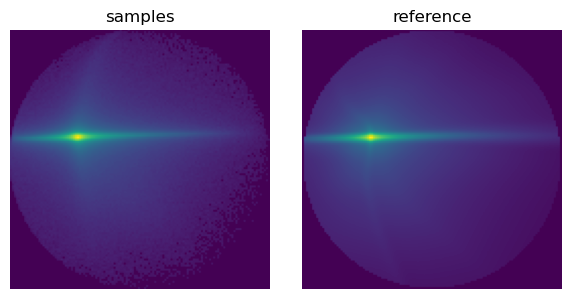

In [10]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(pdf.pow(1/4.2))
plt.title('samples')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(rgb.mean(-1).pow(1/4.2))
plt.title('reference')
plt.axis('off')
plt.tight_layout()